<h1>
<center>CFRM 421/521, Spring 2022</center>
</h1>

<h1>
<center>Shengbo Jin</center>
</h1>

<h1>
<center>Homework 4</center>
</h1>

* **Due: Tuesday, May 31, 2022, 11:59 PM**


* Total marks: 47


* Late submissions are allowed, but a 20% penalty per day applies. Your last submission is considered for calculating the penalty.


*  Use this Jupyter notebook as a template for your solutions. **Your solution must be submitted as one Jupyter notebook on Canvas and one PDF file on Gradescope.** The notebook must be already run, that is, make sure that you have run all your code, save the notebook, and then when you reopen the notebook, checked that all output appears as expected. You are allowed to use code from the textbook, textbook website, or lecture notes.

# 1. A regression MLP [10 marks]

Consider the California housing data from Homework 1 using the same training and test set there. Here, we split off 20% of the training set as a validation set, and keep the remaining 80% as the actual training set.  The following code replicates the preprocessing of the dataset from Homework 1, creating the training set `X_train`, `y_train`, the validation set `X_valid`, `y_valid` and the test set `X_test`, `y_test`. The target variable has been divided by 100,000.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit

import os
import tarfile
from six.moves import urllib

HOUSING_PATH = os.path.join("datasets", "housing")

def fetch_housing_data(housing_url, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

HOUSING_URL = ("https://raw.githubusercontent.com/ageron/"+
               "handson-ml2/master/datasets/housing/housing.tgz")
fetch_housing_data(HOUSING_URL)
data = load_housing_data()

data["income_cat"] = np.ceil(data["median_income"] / 1.5)
data["income_cat"].where(data["income_cat"] < 5, 5.0, inplace=True)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["income_cat"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]
    
# Split the traning set into training and validation    
split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index2, valid_index in split2.split(strat_train_set, strat_train_set["income_cat"]):
    strat_train2_set = strat_train_set.iloc[train_index2]
    strat_valid_set = strat_train_set.iloc[valid_index]
    
strat_train_set = strat_train2_set.copy().drop("income_cat", axis=1)
strat_valid_set = strat_valid_set.copy().drop("income_cat", axis=1)
strat_test_set = strat_test_set.copy().drop("income_cat", axis=1)

X_raw = strat_train_set.drop("median_house_value", axis=1)
y_train = strat_train_set["median_house_value"].copy()/100000

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
num_features = X_raw.drop("ocean_proximity", axis=1)
num_attribs = list(num_features)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

# Apply the pipeline to the training set
X_train = full_pipeline.fit_transform(X_raw)

# Apply the pipeline to the validation set
X_valid_raw = strat_valid_set.drop("median_house_value", axis=1)
y_valid = strat_valid_set["median_house_value"].copy()/100000
X_valid = full_pipeline.transform(X_valid_raw)

# Apply the pipeline to the validation set
X_test_raw = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()/100000
X_test = full_pipeline.transform(X_test_raw)

## (a) [4 marks]

Use `tensorflow.keras` to train a regression MLP with one hidden layer of 50 ReLU neurons. For the output layer, try both a ReLU activation function and no activation function (which is equivalent to the identity function). Explain which choice is better. Use the appropriate weight initialization. Use the Nadam optimizer. Train for 30 epochs, and report the mean squared error on the validation set.

Hint: In the `.compile()` method, use `loss="mse"`.

**[Add your solution here]**

### ReLU activation function for the output layer

In [3]:
import random as python_random

def reset_session(seed=42):
    tf.random.set_seed(seed)
    python_random.seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()

In [4]:
reset_session()
model = keras.models.Sequential([
    keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1, activation="relu", kernel_initializer="he_normal")
])

optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss="mse",
              optimizer=optimizer,
              metrics=["mse"])

model.fit(X_train, y_train, epochs=30,
          validation_data=(X_valid, y_valid))

model.evaluate(X_valid, y_valid)

Epoch 1/30
413/413 [==============================] - 1s 867us/step - loss: 1.2245 - mse: 1.2245 - val_loss: 0.5247 - val_mse: 0.5247
Epoch 2/30
413/413 [==============================] - 0s 630us/step - loss: 0.4593 - mse: 0.4593 - val_loss: 0.4519 - val_mse: 0.4519
Epoch 3/30
413/413 [==============================] - 0s 617us/step - loss: 0.4132 - mse: 0.4132 - val_loss: 0.4150 - val_mse: 0.4150
Epoch 4/30
413/413 [==============================] - 0s 639us/step - loss: 0.3927 - mse: 0.3927 - val_loss: 0.3970 - val_mse: 0.3970
Epoch 5/30
413/413 [==============================] - 0s 632us/step - loss: 0.3811 - mse: 0.3811 - val_loss: 0.3847 - val_mse: 0.3847
Epoch 6/30
413/413 [==============================] - 0s 636us/step - loss: 0.3725 - mse: 0.3725 - val_loss: 0.3765 - val_mse: 0.3765
Epoch 7/30
413/413 [==============================] - 0s 623us/step - loss: 0.3664 - mse: 0.3664 - val_loss: 0.3754 - val_mse: 0.3754
Epoch 8/30
413/413 [==============================] - 0s 649us

[0.33857136964797974, 0.33857136964797974]

### No activation function for the output layer

In [5]:
reset_session()
model = keras.models.Sequential([
    keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1, kernel_initializer="glorot_uniform")
])

optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss="mse",
              optimizer=optimizer,
              metrics=["mse"])

model.fit(X_train, y_train, epochs=30,
          validation_data=(X_valid, y_valid))

model.evaluate(X_valid, y_valid)

Epoch 1/30
413/413 [==============================] - 1s 792us/step - loss: 0.7316 - mse: 0.7316 - val_loss: 0.5167 - val_mse: 0.5167
Epoch 2/30
413/413 [==============================] - 0s 641us/step - loss: 0.4489 - mse: 0.4489 - val_loss: 0.4504 - val_mse: 0.4504
Epoch 3/30
413/413 [==============================] - 0s 691us/step - loss: 0.4092 - mse: 0.4092 - val_loss: 0.4174 - val_mse: 0.4174
Epoch 4/30
413/413 [==============================] - 0s 693us/step - loss: 0.3914 - mse: 0.3914 - val_loss: 0.4017 - val_mse: 0.4017
Epoch 5/30
413/413 [==============================] - 0s 636us/step - loss: 0.3808 - mse: 0.3808 - val_loss: 0.3905 - val_mse: 0.3905
Epoch 6/30
413/413 [==============================] - 0s 643us/step - loss: 0.3724 - mse: 0.3724 - val_loss: 0.3824 - val_mse: 0.3824
Epoch 7/30
413/413 [==============================] - 0s 636us/step - loss: 0.3660 - mse: 0.3660 - val_loss: 0.3805 - val_mse: 0.3805
Epoch 8/30
413/413 [==============================] - 0s 643us

[0.339341938495636, 0.339341938495636]

## (b) [5 marks]

Read the section "Fine-Tuning Neural Network Hyperparameters" in the textbook and the corresponding section in the [Jupyter notebook](https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb) on the textbook website. Then use a randomized search to search for the best number of hidden layers, neurons per hidden layer, and learning rate. For the randomized search use 3-fold CV, with 10 iterations, with the number of hidden layers uniformly sampled from $\{0,1,2,3\}$, the number of neurons per layer uniformly from $\{1,2,\dots,100\}$, and the learning rate from the distribution `reciprocal(3e-4, 3e-2)`. Use early stopping with `patience=10`.

**[Add your solution here]**

In [6]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=X_train.shape[1:]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", kernel_initializer="he_normal"))
    model.add(keras.layers.Dense(1, kernel_initializer="glorot_uniform"))
    optimizer = keras.optimizers.Nadam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    model.compile(loss="mse", optimizer=optimizer, metrics=["mse"])
    return model

In [7]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

C:\Users\King48\AppData\Local\Temp\ipykernel_121048\4087176523.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [8]:
reset_session()
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100).tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=30,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/30
276/276 [==============================] - 1s 942us/step - loss: 0.6828 - mse: 0.6828 - val_loss: 0.4731 - val_mse: 0.4731
Epoch 2/30
276/276 [==============================] - 0s 715us/step - loss: 0.4449 - mse: 0.4449 - val_loss: 0.4480 - val_mse: 0.4480
Epoch 3/30
276/276 [==============================] - 0s 727us/step - loss: 0.4357 - mse: 0.4357 - val_loss: 0.4559 - val_mse: 0.4559
Epoch 4/30
276/276 [==============================] - 0s 725us/step - loss: 0.4279 - mse: 0.4279 - val_loss: 0.4210 - val_mse: 0.4210
Epoch 5/30
276/276 [==============================] - 0s 708us/step - loss: 0.4265 - mse: 0.4265 - val_loss: 0.5548 - val_mse: 0.5548
Epoch 6/30
276/276 [==============================] - 0s 706us/step - loss: 0.4292 - mse: 0.4292 - val_loss: 0.4418 - val_mse: 0.4418
Epoch 7/30
276/276 [==============================] - 0s 703us/step - loss: 0.4267 - mse: 0.4267 - val_loss: 0.4240 - val_mse: 0.4240
E

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000001677C747FD0>,
                   param_distributions={'learning_rate': [0.001683454924600351,
                                                          0.02390836445593178,
                                                          0.008731907739399206,
                                                          0.004725396149933917,
                                                          0.0006154014789262348,
                                                          0.0006153331256530192,
                                                          0.0003920021771415983,
                                                          0.01619845322936229,
                                                          0.004779156784872302,
                                                          0.007821074275112...
                                                          0.00502142573

## (c) [1 mark]

Plot the learning curves for the best model in (c). Does it look like the model is overfitting?

**[Add your solution here]**

In [9]:
rnd_search_cv.best_params_

{'n_neurons': 80, 'n_hidden': 3, 'learning_rate': 0.0059640580092043885}

Epoch 1/30
413/413 [==============================] - 1s 979us/step - loss: 0.5139 - mse: 0.5139 - val_loss: 0.6386 - val_mse: 0.6386
Epoch 2/30
413/413 [==============================] - 0s 800us/step - loss: 0.3765 - mse: 0.3765 - val_loss: 0.3438 - val_mse: 0.3438
Epoch 3/30
413/413 [==============================] - 0s 772us/step - loss: 0.3413 - mse: 0.3413 - val_loss: 0.3357 - val_mse: 0.3357
Epoch 4/30
413/413 [==============================] - 0s 772us/step - loss: 0.3295 - mse: 0.3295 - val_loss: 0.3409 - val_mse: 0.3409
Epoch 5/30
413/413 [==============================] - 0s 767us/step - loss: 0.3317 - mse: 0.3317 - val_loss: 0.3203 - val_mse: 0.3203
Epoch 6/30
413/413 [==============================] - 0s 770us/step - loss: 0.3128 - mse: 0.3128 - val_loss: 0.3209 - val_mse: 0.3209
Epoch 7/30
413/413 [==============================] - 0s 760us/step - loss: 0.3106 - mse: 0.3106 - val_loss: 0.3355 - val_mse: 0.3355
Epoch 8/30
413/413 [==============================] - 0s 783us

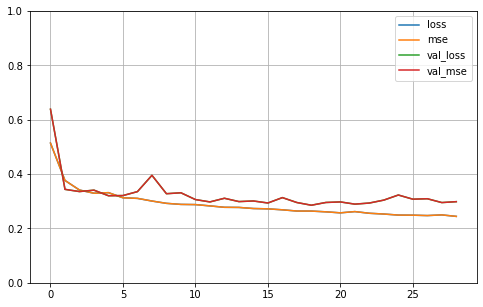

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt

reset_session()
run = rnd_search_cv.best_estimator_.fit(X_train, y_train, epochs=30,
                                        validation_data=(X_valid, y_valid),
                                        callbacks=[keras.callbacks.EarlyStopping(patience=10)])

pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# 2. Binary classification DNN [23 marks]

Consider the [Caravan insurance data](https://liacs.leidenuniv.nl/~puttenpwhvander/library/cc2000/). The data gives sociodemographic and product ownership data from customers of an insurance company, some of which purchased caravan insurance. You can read ther data description from that website. Download the data as a csv file from [Canvas](https://canvas.uw.edu/files/92281351/download?download_frd=1).

The target variable is `Purchase`, which is binary and you should convert it to 1 for `Yes` and 0 for `No`.

## (a) [3 marks]

Load, split and preprocess the data. In particular, for the splitting, you will need to create a test set (20% of the full data), a validation set (20% of the remaining data after creating the test set), and a training set, and stratify using the target variable because this is an imbalanced dataset. For both splits, use `random_state=42`. The features `MOSTYPE` and `MOSHOOFD` are categorical so one hot encoding needs to be applied to them. All other features are numerical so a standard scaler needs to be applied to them. Print the training set `X_train`, `y_train` using `print()`.

**[Add your solution here]**

In [11]:
data = pd.read_csv("caravan.csv")
data["Purchase"] = (data["Purchase"] == "Yes").astype(int)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["Purchase"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index2, valid_index in split2.split(strat_train_set, strat_train_set["Purchase"]):
    strat_train2_set = strat_train_set.iloc[train_index2]
    strat_valid_set = strat_train_set.iloc[valid_index]

X_raw = strat_train2_set.drop("Purchase", axis=1)
y_train = strat_train2_set["Purchase"]

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])
num_features = X_raw.drop(["MOSTYPE","MOSHOOFD"], axis=1)
num_attribs = list(num_features)
cat_attribs = ["MOSTYPE","MOSHOOFD"]
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

X_train = full_pipeline.fit_transform(X_raw)

X_valid_raw = strat_valid_set.drop("Purchase", axis=1)
y_valid = strat_valid_set["Purchase"]
X_valid = full_pipeline.transform(X_valid_raw)

X_test_raw = strat_test_set.drop("Purchase", axis=1)
y_test = strat_test_set["Purchase"]
X_test = full_pipeline.transform(X_test_raw)

In [12]:
print(X_train)

[[-0.26920841  0.40025864  0.00630108 ...  0.          0.
   0.        ]
 [-0.26920841 -0.87080994  1.24164497 ...  0.          0.
   0.        ]
 [-0.26920841 -0.87080994  0.00630108 ...  1.          0.
   0.        ]
 ...
 [-0.26920841  1.67132722  0.00630108 ...  0.          0.
   0.        ]
 [-0.26920841  0.40025864 -1.2290428  ...  0.          0.
   0.        ]
 [-0.26920841  0.40025864  0.00630108 ...  1.          0.
   0.        ]]


In [13]:
print(y_train)

5356    0
2968    0
1180    0
5182    0
2623    0
       ..
219     0
1701    0
5360    0
978     0
4062    0
Name: Purchase, Length: 3725, dtype: int32


## (b) [3 marks]

In the next part (c), you will build and fit a DNN with 5 hidden layers of 200, 200, 100, 100, 50 neurons, respectively. Use the following specifications:

(i) He initialization and the ELU activation function.

(ii) The output layer has 1 neuron with sigmoid activation.

(iii) Compile with `loss="binary_crossentropy"` and  `metrics=["AUC"]` (which is ROC AUC).

In this question, explain why the choices (i), (ii), and (iii) are justified.

**[Add your solution here]**

In [14]:
model_c = keras.models.Sequential()
for n_hidden in (200, 200, 100, 100, 50):
    model_c.add(keras.layers.Dense(n_hidden, activation="elu", kernel_initializer="he_normal"))
model_c.add(keras.layers.Dense(1, activation="sigmoid"))

optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model_c.compile(loss="binary_crossentropy", optimizer=optimizer,
                metrics=["AUC"])

## (c) [3 marks]

Train the model in (b) for 30 epochs and use exponential scheduling and the NAG optimizer with `momentum=0.9`. Use a learning curve to comment on whether it is overfitting.

At the start of fitting your model, run `reset_session()` given by the following code.

In [15]:
import random as python_random

def reset_session(seed=42):
    tf.random.set_seed(seed)
    python_random.seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()

**[Add your solution here]**

Epoch 1/30
117/117 [==============================] - 1s 3ms/step - loss: 0.2462 - auc: 0.6247 - val_loss: 0.2280 - val_auc: 0.6375 - lr: 0.0100
Epoch 2/30
117/117 [==============================] - 0s 1ms/step - loss: 0.1890 - auc: 0.7985 - val_loss: 0.2285 - val_auc: 0.6892 - lr: 0.0089
Epoch 3/30
117/117 [==============================] - 0s 1ms/step - loss: 0.1673 - auc: 0.8563 - val_loss: 0.2353 - val_auc: 0.6605 - lr: 0.0079
Epoch 4/30
117/117 [==============================] - 0s 1ms/step - loss: 0.1548 - auc: 0.8923 - val_loss: 0.2379 - val_auc: 0.6852 - lr: 0.0071
Epoch 5/30
117/117 [==============================] - 0s 2ms/step - loss: 0.1404 - auc: 0.9183 - val_loss: 0.2363 - val_auc: 0.6920 - lr: 0.0063
Epoch 6/30
117/117 [==============================] - 0s 1ms/step - loss: 0.1266 - auc: 0.9383 - val_loss: 0.2624 - val_auc: 0.6872 - lr: 0.0056
Epoch 7/30
117/117 [==============================] - 0s 1ms/step - loss: 0.1178 - auc: 0.9462 - val_loss: 0.2535 - val_auc: 0.682

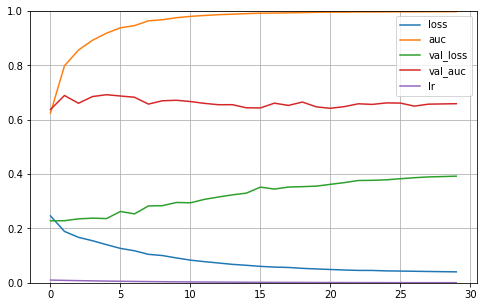

In [16]:
reset_session()
def exponential_decay(lr0, s):
    return lambda epoch: lr0 * 0.1**(epoch / s)
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay(lr0=0.01,s=20))

run = model_c.fit(X_train, y_train, epochs=30,
                  validation_data=(X_valid, y_valid),
                  callbacks=[lr_scheduler])

pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [17]:
model_c.evaluate(X_valid, y_valid)

30/30 [==============================] - 0s 777us/step - loss: 0.3924 - auc: 0.6590


[0.3923604488372803, 0.6589714288711548]

## (d) [12 marks]

Fit separate models using the same specification as in (c) but with the following regularization techniques:

(i) batch normalization,

(ii) early stopping based on validation AUC with `patience=10` (look at the documentation and note the `mode` argument).

(iii) $\ell_2$ regularization with `l2=0.001`,

(iv) dropout with probability 0.2,

(v) $\ell_2$ regularization and early stopping both as above,

(vi) batch normalization and dropout both as above.

At the start of each one of the above models, run `reset_session()`.

The performance measure is validation AUC. State this for the model in (c), and for each of the models here comment on whether it is better than the model in (c).

**[Add your solution here]**

### batch normalization

In [18]:
model_1 = keras.models.Sequential()
for n_hidden in (200, 200, 100, 100, 50):
    model_1.add(keras.layers.BatchNormalization())
    model_1.add(keras.layers.Dense(n_hidden, activation="elu", kernel_initializer="he_normal"))
model_1.add(keras.layers.BatchNormalization())
model_1.add(keras.layers.Dense(1, activation="sigmoid"))

optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model_1.compile(loss="binary_crossentropy", optimizer=optimizer,
                metrics=["AUC"])

In [19]:
reset_session()

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay(lr0=0.01,s=20))
run = model_1.fit(X_train, y_train, epochs=30,
                  validation_data=(X_valid, y_valid),
                  callbacks=[lr_scheduler])

model_1.evaluate(X_valid, y_valid)

Epoch 1/30
117/117 [==============================] - 2s 4ms/step - loss: 0.2996 - auc: 0.6198 - val_loss: 0.2203 - val_auc: 0.6598 - lr: 0.0100
Epoch 2/30
117/117 [==============================] - 0s 2ms/step - loss: 0.1969 - auc: 0.7746 - val_loss: 0.2269 - val_auc: 0.6643 - lr: 0.0089
Epoch 3/30
117/117 [==============================] - 0s 2ms/step - loss: 0.1781 - auc: 0.8368 - val_loss: 0.2295 - val_auc: 0.6644 - lr: 0.0079
Epoch 4/30
117/117 [==============================] - 0s 2ms/step - loss: 0.1708 - auc: 0.8523 - val_loss: 0.2371 - val_auc: 0.6488 - lr: 0.0071
Epoch 5/30
117/117 [==============================] - 0s 2ms/step - loss: 0.1557 - auc: 0.8902 - val_loss: 0.2486 - val_auc: 0.6516 - lr: 0.0063
Epoch 6/30
117/117 [==============================] - 0s 2ms/step - loss: 0.1461 - auc: 0.9118 - val_loss: 0.2481 - val_auc: 0.6674 - lr: 0.0056
Epoch 7/30
117/117 [==============================] - 0s 2ms/step - loss: 0.1414 - auc: 0.9170 - val_loss: 0.2525 - val_auc: 0.660

[0.32942235469818115, 0.6282310485839844]

### early stopping

In [20]:
model_2 = keras.models.Sequential()
for n_hidden in (200, 200, 100, 100, 50):
    model_2.add(keras.layers.Dense(n_hidden, activation="elu", kernel_initializer="he_normal"))
model_2.add(keras.layers.Dense(1, activation="sigmoid"))

optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model_2.compile(loss="binary_crossentropy", optimizer=optimizer,
                metrics=["AUC"])

In [21]:
reset_session()

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay(lr0=0.01,s=20))
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_auc",
                                                  patience=10,
                                                  mode="max")
run = model_2.fit(X_train, y_train, epochs=30,
                  validation_data=(X_valid, y_valid),
                  callbacks=[lr_scheduler, early_stopping_cb])

model_2.evaluate(X_valid, y_valid)

Epoch 1/30
117/117 [==============================] - 1s 3ms/step - loss: 0.2462 - auc: 0.6247 - val_loss: 0.2280 - val_auc: 0.6375 - lr: 0.0100
Epoch 2/30
117/117 [==============================] - 0s 1ms/step - loss: 0.1890 - auc: 0.7985 - val_loss: 0.2285 - val_auc: 0.6892 - lr: 0.0089
Epoch 3/30
117/117 [==============================] - 0s 1ms/step - loss: 0.1673 - auc: 0.8563 - val_loss: 0.2353 - val_auc: 0.6605 - lr: 0.0079
Epoch 4/30
117/117 [==============================] - 0s 1ms/step - loss: 0.1548 - auc: 0.8923 - val_loss: 0.2379 - val_auc: 0.6852 - lr: 0.0071
Epoch 5/30
117/117 [==============================] - 0s 2ms/step - loss: 0.1404 - auc: 0.9183 - val_loss: 0.2363 - val_auc: 0.6920 - lr: 0.0063
Epoch 6/30
117/117 [==============================] - 0s 1ms/step - loss: 0.1266 - auc: 0.9383 - val_loss: 0.2624 - val_auc: 0.6872 - lr: 0.0056
Epoch 7/30
117/117 [==============================] - 0s 1ms/step - loss: 0.1178 - auc: 0.9462 - val_loss: 0.2535 - val_auc: 0.682

[0.3299334943294525, 0.6438356041908264]

### $\ell_2$ regularization

In [22]:
model_3 = keras.models.Sequential()
for n_hidden in (200, 200, 100, 100, 50):
    model_3.add(keras.layers.Dense(n_hidden, activation="elu", kernel_initializer="he_normal",
                                 kernel_regularizer=keras.regularizers.l2(0.01)))
model_3.add(keras.layers.Dense(1, activation="sigmoid", kernel_regularizer=keras.regularizers.l2(0.01)))

optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model_3.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["AUC"])

In [23]:
reset_session()

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay(lr0=0.01,s=20))
run = model_3.fit(X_train, y_train, epochs=30,
                  validation_data=(X_valid, y_valid),
                  callbacks=[lr_scheduler])

model_3.evaluate(X_valid, y_valid)

Epoch 1/30
117/117 [==============================] - 1s 3ms/step - loss: 11.0016 - auc: 0.6298 - val_loss: 8.6342 - val_auc: 0.6415 - lr: 0.0100
Epoch 2/30
117/117 [==============================] - 0s 1ms/step - loss: 7.0640 - auc: 0.7592 - val_loss: 5.7258 - val_auc: 0.6799 - lr: 0.0089
Epoch 3/30
117/117 [==============================] - 0s 1ms/step - loss: 4.7906 - auc: 0.7793 - val_loss: 3.9987 - val_auc: 0.6809 - lr: 0.0079
Epoch 4/30
117/117 [==============================] - 0s 1ms/step - loss: 3.4160 - auc: 0.7737 - val_loss: 2.9242 - val_auc: 0.6868 - lr: 0.0071
Epoch 5/30
117/117 [==============================] - 0s 1ms/step - loss: 2.5456 - auc: 0.7769 - val_loss: 2.2308 - val_auc: 0.6845 - lr: 0.0063
Epoch 6/30
117/117 [==============================] - 0s 1ms/step - loss: 1.9736 - auc: 0.7828 - val_loss: 1.7682 - val_auc: 0.6803 - lr: 0.0056
Epoch 7/30
117/117 [==============================] - 0s 1ms/step - loss: 1.5860 - auc: 0.7831 - val_loss: 1.4474 - val_auc: 0.68

[0.4539940655231476, 0.6783064603805542]

### dropout

In [24]:
model_4 = keras.models.Sequential()
for n_hidden in (200, 200, 100, 100, 50):
    model_4.add(keras.layers.Dropout(rate=0.2))
    model_4.add(keras.layers.Dense(n_hidden, activation="elu", kernel_initializer="he_normal"))
model_4.add(keras.layers.Dropout(rate=0.2))
model_4.add(keras.layers.Dense(1, activation="sigmoid"))

optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model_4.compile(loss="binary_crossentropy", optimizer=optimizer,
                metrics=["AUC"])

In [25]:
reset_session()

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay(lr0=0.01,s=20))
run = model_4.fit(X_train, y_train, epochs=30,
                  validation_data=(X_valid, y_valid),
                  callbacks=[lr_scheduler])

model_4.evaluate(X_valid, y_valid)

Epoch 1/30
117/117 [==============================] - 1s 3ms/step - loss: 0.3058 - auc: 0.5553 - val_loss: 0.2244 - val_auc: 0.6413 - lr: 0.0100
Epoch 2/30
117/117 [==============================] - 0s 2ms/step - loss: 0.2307 - auc: 0.6401 - val_loss: 0.2250 - val_auc: 0.6630 - lr: 0.0089
Epoch 3/30
117/117 [==============================] - 0s 2ms/step - loss: 0.2138 - auc: 0.7120 - val_loss: 0.2220 - val_auc: 0.6764 - lr: 0.0079
Epoch 4/30
117/117 [==============================] - 0s 2ms/step - loss: 0.2178 - auc: 0.6871 - val_loss: 0.2192 - val_auc: 0.6644 - lr: 0.0071
Epoch 5/30
117/117 [==============================] - 0s 2ms/step - loss: 0.2179 - auc: 0.6808 - val_loss: 0.2178 - val_auc: 0.6809 - lr: 0.0063
Epoch 6/30
117/117 [==============================] - 0s 2ms/step - loss: 0.2103 - auc: 0.7148 - val_loss: 0.2211 - val_auc: 0.6811 - lr: 0.0056
Epoch 7/30
117/117 [==============================] - 0s 2ms/step - loss: 0.2117 - auc: 0.7114 - val_loss: 0.2174 - val_auc: 0.684

[0.2199716717004776, 0.6928408741950989]

### $\ell_2$ regularization and early stopping

In [27]:
model_5 = keras.models.Sequential()
for n_hidden in (200, 200, 100, 100, 50):
    model_5.add(keras.layers.Dense(n_hidden, activation="elu", kernel_initializer="he_normal",
                                 kernel_regularizer=keras.regularizers.l2(0.01)))
model_5.add(keras.layers.Dense(1, activation="sigmoid", kernel_regularizer=keras.regularizers.l2(0.01)))

optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model_5.compile(loss="binary_crossentropy", optimizer=optimizer,
                metrics=["AUC"])

In [28]:
reset_session()

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay(lr0=0.01,s=20))
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_auc",
                                                  patience=10,
                                                  mode="max")
run = model_5.fit(X_train, y_train, epochs=30,
                  validation_data=(X_valid, y_valid),
                  callbacks=[lr_scheduler, early_stopping_cb])

model_5.evaluate(X_valid, y_valid)

Epoch 1/30
117/117 [==============================] - 1s 3ms/step - loss: 11.0016 - auc: 0.6298 - val_loss: 8.6342 - val_auc: 0.6415 - lr: 0.0100
Epoch 2/30
117/117 [==============================] - 0s 2ms/step - loss: 7.0640 - auc: 0.7592 - val_loss: 5.7258 - val_auc: 0.6799 - lr: 0.0089
Epoch 3/30
117/117 [==============================] - 0s 2ms/step - loss: 4.7906 - auc: 0.7793 - val_loss: 3.9987 - val_auc: 0.6809 - lr: 0.0079
Epoch 4/30
117/117 [==============================] - 0s 2ms/step - loss: 3.4160 - auc: 0.7737 - val_loss: 2.9242 - val_auc: 0.6868 - lr: 0.0071
Epoch 5/30
117/117 [==============================] - 0s 1ms/step - loss: 2.5456 - auc: 0.7769 - val_loss: 2.2308 - val_auc: 0.6845 - lr: 0.0063
Epoch 6/30
117/117 [==============================] - 0s 1ms/step - loss: 1.9736 - auc: 0.7828 - val_loss: 1.7682 - val_auc: 0.6803 - lr: 0.0056
Epoch 7/30
117/117 [==============================] - 0s 2ms/step - loss: 1.5860 - auc: 0.7831 - val_loss: 1.4474 - val_auc: 0.68

[0.6632557511329651, 0.6784287095069885]

### batch normalization and dropout

In [29]:
model_6 = keras.models.Sequential()
for n_hidden in (200, 200, 100, 100, 50):
    model_6.add(keras.layers.BatchNormalization())
    model_6.add(keras.layers.Dropout(rate=0.2))
    model_6.add(keras.layers.Dense(n_hidden, activation="elu", kernel_initializer="he_normal"))
model_6.add(keras.layers.BatchNormalization())
model_6.add(keras.layers.Dropout(rate=0.2))
model_6.add(keras.layers.Dense(1, activation="sigmoid"))

optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model_6.compile(loss="binary_crossentropy", optimizer=optimizer,
                metrics=["AUC"])

In [30]:
reset_session()

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay(lr0=0.01,s=20))
run = model_6.fit(X_train, y_train, epochs=30,
                  validation_data=(X_valid, y_valid),
                  callbacks=[lr_scheduler])

model_6.evaluate(X_valid, y_valid)

Epoch 1/30
117/117 [==============================] - 2s 4ms/step - loss: 0.3421 - auc: 0.5378 - val_loss: 0.2179 - val_auc: 0.6722 - lr: 0.0100
Epoch 2/30
117/117 [==============================] - 0s 3ms/step - loss: 0.2338 - auc: 0.5864 - val_loss: 0.2185 - val_auc: 0.6622 - lr: 0.0089
Epoch 3/30
117/117 [==============================] - 0s 3ms/step - loss: 0.2212 - auc: 0.6618 - val_loss: 0.2145 - val_auc: 0.6880 - lr: 0.0079
Epoch 4/30
117/117 [==============================] - 0s 3ms/step - loss: 0.2196 - auc: 0.6706 - val_loss: 0.2155 - val_auc: 0.6770 - lr: 0.0071
Epoch 5/30
117/117 [==============================] - 0s 3ms/step - loss: 0.2160 - auc: 0.6752 - val_loss: 0.2131 - val_auc: 0.6954 - lr: 0.0063
Epoch 6/30
117/117 [==============================] - 0s 3ms/step - loss: 0.2119 - auc: 0.6994 - val_loss: 0.2143 - val_auc: 0.6977 - lr: 0.0056
Epoch 7/30
117/117 [==============================] - 0s 3ms/step - loss: 0.2088 - auc: 0.7188 - val_loss: 0.2159 - val_auc: 0.683

[0.21742799878120422, 0.6829541921615601]

## (e) [1 mark]

For the dropout model in (d)(iv) determine whether or not it is overfitting less than the model in (c).

**[Add your solution here]**

Epoch 1/30
117/117 [==============================] - 0s 3ms/step - loss: 0.1695 - auc: 0.8574 - val_loss: 0.2283 - val_auc: 0.6803 - lr: 0.0100
Epoch 2/30
117/117 [==============================] - 0s 2ms/step - loss: 0.1777 - auc: 0.8290 - val_loss: 0.2469 - val_auc: 0.6680 - lr: 0.0089
Epoch 3/30
117/117 [==============================] - 0s 2ms/step - loss: 0.1770 - auc: 0.8358 - val_loss: 0.2375 - val_auc: 0.6991 - lr: 0.0079
Epoch 4/30
117/117 [==============================] - 0s 2ms/step - loss: 0.1855 - auc: 0.8121 - val_loss: 0.2224 - val_auc: 0.6767 - lr: 0.0071
Epoch 5/30
117/117 [==============================] - 0s 2ms/step - loss: 0.1925 - auc: 0.7910 - val_loss: 0.2202 - val_auc: 0.6924 - lr: 0.0063
Epoch 6/30
117/117 [==============================] - 0s 2ms/step - loss: 0.1863 - auc: 0.7996 - val_loss: 0.2278 - val_auc: 0.6984 - lr: 0.0056
Epoch 7/30
117/117 [==============================] - 0s 2ms/step - loss: 0.1902 - auc: 0.7942 - val_loss: 0.2191 - val_auc: 0.697

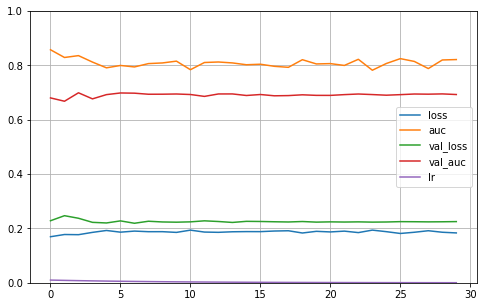

In [33]:
reset_session()

run = model_4.fit(X_train, y_train, epochs=30,
                  validation_data=(X_valid, y_valid),
                  callbacks=[lr_scheduler])

pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Epoch 1/30
117/117 [==============================] - 0s 2ms/step - loss: 0.1254 - auc: 0.9331 - val_loss: 0.3421 - val_auc: 0.6278 - lr: 0.0100
Epoch 2/30
117/117 [==============================] - 0s 1ms/step - loss: 0.1031 - auc: 0.9635 - val_loss: 0.3589 - val_auc: 0.6873 - lr: 0.0089
Epoch 3/30
117/117 [==============================] - 0s 1ms/step - loss: 0.0831 - auc: 0.9777 - val_loss: 0.3820 - val_auc: 0.6296 - lr: 0.0079
Epoch 4/30
117/117 [==============================] - 0s 2ms/step - loss: 0.0716 - auc: 0.9865 - val_loss: 0.3692 - val_auc: 0.6471 - lr: 0.0071
Epoch 5/30
117/117 [==============================] - 0s 1ms/step - loss: 0.0560 - auc: 0.9922 - val_loss: 0.3919 - val_auc: 0.6518 - lr: 0.0063
Epoch 6/30
117/117 [==============================] - 0s 1ms/step - loss: 0.0516 - auc: 0.9927 - val_loss: 0.4399 - val_auc: 0.6224 - lr: 0.0056
Epoch 7/30
117/117 [==============================] - 0s 1ms/step - loss: 0.0475 - auc: 0.9931 - val_loss: 0.4250 - val_auc: 0.600

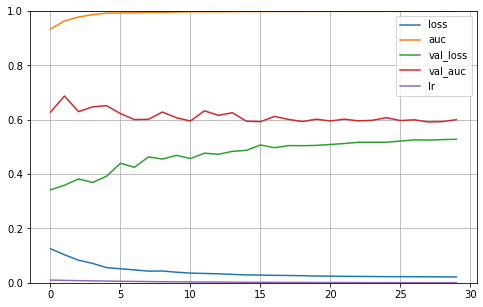

In [34]:
reset_session()

run = model_c.fit(X_train, y_train, epochs=30,
                  validation_data=(X_valid, y_valid),
                  callbacks=[lr_scheduler])

pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## (f) [1 mark]

Of the models in (c) and (d), one would now choose the best model according to the performance metric (validation AUC) to evaluate on the test set. But instead, evaluate the model in (d)(v) on the test set in terms of the AUC and confusion matrix (regardless of whether it is the best model given your results).

**[Add your solution here]**

In [35]:
reset_session()

model_5.evaluate(X_test, y_test)

37/37 [==============================] - 0s 757us/step - loss: 0.6482 - auc: 0.7945


[0.6482296586036682, 0.7945270538330078]

In [36]:
tf.math.confusion_matrix(y_test, model_5.predict(X_test))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1095,    0],
       [  70,    0]])>

# 3. Time series using machine learning [14 marks]

Obtain daily values of the [Japan/U.S. Foreign Exchange Rate (DEXJPUS)](https://fred.stlouisfed.org/series/DEXJPUS) starting from Jan 1, 1990, to Jan 1, 2022, from FRED. This can be obtained using the code below or you can download the data as a csv file from [Canvas](https://canvas.uw.edu/files/92281350/download?download_frd=1).

In [43]:
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
data = pdr.get_data_fred('DEXJPUS', datetime(1990,1,1),datetime(2022,1,1))

## (a) [2 marks]

Create a training set (before 2010), a validation set (Jan 2010 to Dec 2015), and a test set (the rest of the data). Turn the time series data into a supervised learning dataset where the features are the value of the exchange rate in the last 10 days inclusive of the current day, and the target is the value of the exchange rate in the next day.

**[Add your solution here]**

In [133]:
train = data[:'2009-12-31'].dropna()
valid = data['2010-1-1':'2015-12-31'].dropna()
test = data['2016-1-1':].dropna()

In [134]:
def ts_split(ts, feature_steps=8, target_steps=1):
    ts = ts.values.flatten()
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
    y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps]
                  for idx in range(n_obs)])
    return X, y

In [135]:
X_train, y_train = ts_split(train, feature_steps=10, target_steps=1)
X_valid, y_valid = ts_split(valid, feature_steps=10, target_steps=1)
X_test, y_test = ts_split(test, feature_steps=10, target_steps=1)

## (b) [3 marks]

Fit a random forest regressor to predict the value of the exchange rate in the next day. Using the test set, report the mean squared error and the accuracy for the movement direction.

Hint: You can calculate the accuracy of the movement direction by determining what the actual movement direction is and comparing it to the movement direction corresponding to the predicted value of the exchange rate. For instance, the movement direction of the test set `X_test` and `y_test` where a strictly up movement is `True` can be computed as follows.

In [137]:
movement_test = X_test[:,-1] < y_test.ravel()

**[Add your solution here]**

In [138]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf_reg = RandomForestRegressor(n_jobs=-1, random_state=42)
rf_reg.fit(X_train, y_train)

y_pred = rf_reg.predict(X_test)
mean_squared_error(y_test, y_pred)

C:\Users\King48\AppData\Local\Temp\ipykernel_121048\4272059818.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg.fit(X_train, y_train)


0.3738088196839274

In [139]:
movement_pred = X_test[:,-1] < y_pred.ravel()

In [140]:
from sklearn.metrics import accuracy_score

accuracy_score(movement_test, movement_pred)

0.5137861466039004

## (c) [4 marks]

Repeat (b), but now fit a deep RNN with 2 recurrent layers of 20 and 20 neurons, and an output layer which is 1 dense neuron. Use 100 epochs and the Nadam optimizer. Comment on the result and the learning curve (the validation set is used for the learning curve).

**[Add your solution here]**

In [141]:
reset_session()

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="nadam")

run = model.fit(X_train[..., np.newaxis], y_train, epochs=100,
                validation_data=(X_valid[..., np.newaxis], y_valid))

Epoch 1/100
157/157 [==============================] - 2s 3ms/step - loss: 12316.5762 - val_loss: 7888.1206
Epoch 2/100
157/157 [==============================] - 0s 2ms/step - loss: 11368.5762 - val_loss: 7278.5903
Epoch 3/100
157/157 [==============================] - 0s 2ms/step - loss: 10654.5889 - val_loss: 6730.1587
Epoch 4/100
157/157 [==============================] - 0s 2ms/step - loss: 9994.9902 - val_loss: 6220.2866
Epoch 5/100
157/157 [==============================] - 0s 2ms/step - loss: 9373.0195 - val_loss: 5741.7114
Epoch 6/100
157/157 [==============================] - 0s 2ms/step - loss: 8783.2744 - val_loss: 5291.3369
Epoch 7/100
157/157 [==============================] - 0s 2ms/step - loss: 8222.8760 - val_loss: 4867.1123
Epoch 8/100
157/157 [==============================] - 0s 2ms/step - loss: 7689.8506 - val_loss: 4467.5356
Epoch 9/100
157/157 [==============================] - 0s 2ms/step - loss: 7182.8135 - val_loss: 4091.6309
Epoch 10/100
157/157 [============

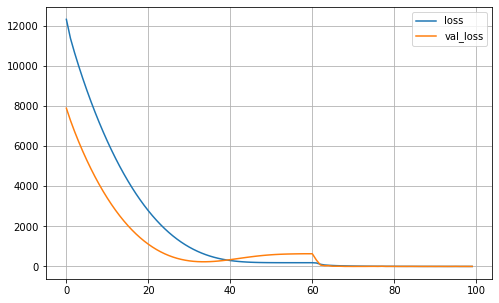

In [142]:
pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

## (d) [5 marks]

Create a supervised learning dataset suitable for predicting 3 days ahead instead of 1 day ahead. Adjust the deep RNN in (c) so that it predicts 3 days ahead. Use 100 epochs and the Nadam optimizer. Using the test set, report the mean squared error and the accuracy for the movement direction for each of the 3 days ahead predictions.  Comment on the result and the learning curve.

**[Add your solution here]**

In [143]:
X_train_3ahead, y_train_3ahead = ts_split(train, feature_steps=10, target_steps=3)
X_valid_3ahead, y_valid_3ahead = ts_split(valid, feature_steps=10, target_steps=3)
X_test_3ahead, y_test_3ahead = ts_split(test, feature_steps=10, target_steps=3)

In [144]:
reset_session()

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1)),
    keras.layers.Lambda(lambda Y_pred: Y_pred[:, -3:])
])

model.compile(loss="mse", optimizer="nadam")

run = model.fit(X_train_3ahead[..., np.newaxis],
                y_train_3ahead[..., np.newaxis],
                epochs=100,
                validation_data=(X_valid_3ahead[..., np.newaxis],
                                 y_valid_3ahead[..., np.newaxis]))

Epoch 1/100
157/157 [==============================] - 2s 3ms/step - loss: 12311.9678 - val_loss: 7877.4678
Epoch 2/100
157/157 [==============================] - 0s 2ms/step - loss: 11363.8887 - val_loss: 7277.3262
Epoch 3/100
157/157 [==============================] - 0s 2ms/step - loss: 10657.6963 - val_loss: 6731.9331
Epoch 4/100
157/157 [==============================] - 0s 2ms/step - loss: 10000.3809 - val_loss: 6223.1577
Epoch 5/100
157/157 [==============================] - 0s 2ms/step - loss: 9379.6641 - val_loss: 5745.3638
Epoch 6/100
157/157 [==============================] - 0s 2ms/step - loss: 8790.7266 - val_loss: 5295.4888
Epoch 7/100
157/157 [==============================] - 0s 2ms/step - loss: 8230.8408 - val_loss: 4871.6479
Epoch 8/100
157/157 [==============================] - 0s 2ms/step - loss: 7698.0371 - val_loss: 4472.1851
Epoch 9/100
157/157 [==============================] - 0s 2ms/step - loss: 7190.8887 - val_loss: 4096.1592
Epoch 10/100
157/157 [===========

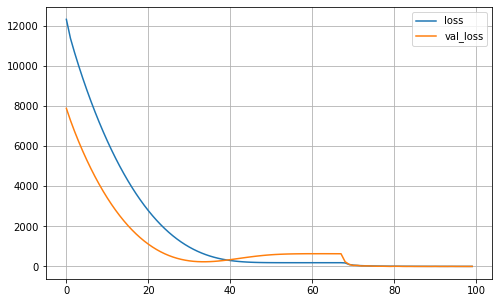

In [145]:
pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [146]:
ypred = model.predict(X_test_3ahead[...,np.newaxis])[...,0]
mean_squared_error(y_test_3ahead, ypred, multioutput="raw_values")

array([1.11196707, 1.12583179, 1.13190437])

In [156]:
movement_test_1ahead = X_test_3ahead[:,-1] < y_test_3ahead[:,0].ravel()
movement_pred_1ahead = X_test_3ahead[:,-1] < ypred[:,0].ravel()
accuracy_score(movement_test_1ahead, movement_pred_1ahead)

0.49158249158249157

In [157]:
movement_test_2ahead = X_test_3ahead[:,-1] < y_test_3ahead[:,1].ravel()
movement_pred_2ahead = X_test_3ahead[:,-1] < ypred[:,1].ravel()
accuracy_score(movement_test_2ahead, movement_pred_2ahead)

0.4909090909090909

In [158]:
movement_test_3ahead = X_test_3ahead[:,-1] < y_test_3ahead[:,2].ravel()
movement_pred_3ahead = X_test_3ahead[:,-1] < ypred[:,2].ravel()
accuracy_score(movement_test_3ahead, movement_pred_3ahead)

0.5151515151515151